In [270]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

### Load Libraries

In [271]:
import os
import re
import pickle
import numpy as np
import pandas as pd
from copy import deepcopy

### Load Data

In [272]:
RAW_DIR_PATH = os.path.join("./data_raw")
PROCESSED_DIR_PATH = os.path.join("./data_processed")

In [273]:
df = pd.read_csv(os.path.join(RAW_DIR_PATH, "resale_flat_prices", "resale_flat_prices_all.csv"))

print(df.shape, '\n', df.columns)
display(df.head(3))

(880848, 12) 
 Index(['Unnamed: 0', 'month', 'town', 'flat_type', 'block', 'street_name',
       'storey_range', 'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'resale_price', 'remaining_lease'],
      dtype='object')


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Unnamed: 0,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease
0,0,1990-01,JURONG WEST,3 ROOM,172,BOON LAY DR,04 TO 06,70.0,IMPROVED,1974,23400.0,NaN
1,1,1990-01,JURONG EAST,4 ROOM,322,JURONG EAST ST 31,07 TO 09,96.0,NEW GENERATION,1985,70000.0,NaN
2,2,1990-01,JURONG EAST,4 ROOM,218,JURONG EAST ST 21,10 TO 12,91.0,NEW GENERATION,1984,72000.0,NaN


### Data Processing

#### Processor

In [274]:
def process_hdb(df):
    tx = deepcopy(df)
    
    # Drop duplicated transactions
    drop_dup_idx = tx[tx.duplicated()].index
    tx.drop(drop_dup_idx, axis=0, inplace=True)
    
    # Create numerical ID
    tx.reset_index(drop=True, inplace=True)
    tx.index = tx.index + 1
    
    # Make sale date column to be datetime 
    tx['sale_date'] = pd.to_datetime(tx.month)
    
    # Coerce low count categories to OTHER
    low_ct_towns = tx.town.value_counts()[tx.town.value_counts() < 12000].index
    low_ct_flat_types = tx.flat_type.value_counts()[tx.flat_type.value_counts() < 50000].index
    low_ct_flat_models = tx.flat_model.value_counts()[tx.flat_model.value_counts() < 9000].index
    
    tx.town = tx.town.apply(lambda t: 'OTHER' if t in low_ct_towns else '_'.join(t.upper().split()))
    tx.flat_type = tx.flat_type.apply(lambda ft: 'OTHER' if ft in low_ct_flat_types else '_'.join(ft.upper().split()))
    tx.flat_model = tx.flat_model.apply(lambda fm: 'OTHER' if fm in low_ct_flat_models else '_'.join(fm.upper().split()))
    
    # Get floor number as middle of floor range
    tx['floor_l'] = tx.storey_range.str.extract(r'([0-9]+) TO')
    tx['floor_u'] = tx.storey_range.str.extract(r'TO ([0-9]+)')
    tx['floor'] = (tx.floor_u.astype(float) + tx.floor_l.astype(float)) / 2.0
    
    # Calculate building age and coerce -ve ages to 0 (small num of obs with -1, -2)
    tx['age'] = tx.sale_date.dt.year - tx.lease_commence_date
    tx.age = tx.age.clip(lower = 0)
    
    # Fill in missing remaining_lease
    tx.remaining_lease = 99.0 - tx.age
    
    # Calculate relative_tenure
    tx['relative_tenure'] = 1.0 - 1.0 / ( ( 1.0 + tx.remaining_lease / 208.96) ** 6.8828 )
    
    # Get floor area and price per sqm
    tx['floor_area'] = tx.floor_area_sqm
    tx['psm'] = tx.resale_price / tx.floor_area
    tx['address'] = "BLOCK " + tx.block + " " + tx.street_name

    keep_cols = ['psm', 'sale_date', 
                 'floor_area', 'floor', 'age', 'relative_tenure', 
                 'town', 'address', 'flat_type', 'flat_model', 'period']
    
    drop_cols = list(set(tx.columns).difference(set(keep_cols)))
    tx.drop(drop_cols, axis=1, inplace=True)
    return tx

#### Process data

In [275]:
tx = process_hdb(df)

print(tx.shape, '\n', tx.columns)
display(tx.head(3))

(880848, 10) 
 Index(['town', 'flat_type', 'flat_model', 'sale_date', 'floor', 'age',
       'relative_tenure', 'floor_area', 'psm', 'address'],
      dtype='object')


,town,flat_type,flat_model,sale_date,floor,age,relative_tenure,floor_area,psm,address
1,JURONG_WEST,3_ROOM,IMPROVED,1990-01-01,5.0,16,0.899953,70.0,334.285714,BLOCK 172 BOON LAY DR
2,JURONG_EAST,4_ROOM,NEW_GENERATION,1990-01-01,8.0,5,0.922437,96.0,729.166667,BLOCK 322 JURONG EAST ST 31
3,JURONG_EAST,4_ROOM,NEW_GENERATION,1990-01-01,11.0,6,0.920652,91.0,791.208791,BLOCK 218 JURONG EAST ST 21


### Feature Engineering

#### Feature provider

In [276]:
def get_features(tx):
    features = {
        'period': pd.PeriodIndex(tx.sale_date, freq='Q'), 
        'log_psm': np.log(tx.psm), 
        'log_floor_area': np.log(tx.floor_area), 
        'log_floor': np.log(tx.floor), 
        'log_age': np.log(tx.age+1), 
        'relative_tenure': tx.relative_tenure, 
        'flat_type': tx.flat_type, 
        'flat_model': tx.flat_model, 
        'town': tx.town
    }
    ft = pd.DataFrame(features)
    ft = pd.get_dummies(ft, 
                        columns = ['flat_type', 'flat_model', 'town'], 
                        prefix = ['flat_type', 'flat_model', 'town'], 
                        drop_first = True)
    ft = pd.get_dummies(ft, columns = ['period'])
    return ft

In [277]:
ft = get_features(tx)

print(ft.shape, '\n', ft.columns)
display(ft.head(3))

(880848, 172) 
 Index(['log_psm', 'log_floor_area', 'log_floor', 'log_age', 'relative_tenure',
       'flat_type_4_ROOM', 'flat_type_5_ROOM', 'flat_type_EXECUTIVE',
       'flat_type_OTHER', 'flat_model_IMPROVED',
       ...
       'period_2020Q2', 'period_2020Q3', 'period_2020Q4', 'period_2021Q1',
       'period_2021Q2', 'period_2021Q3', 'period_2021Q4', 'period_2022Q1',
       'period_2022Q2', 'period_2022Q3'],
      dtype='object', length=172)


,log_psm,log_floor_area,log_floor,log_age,relative_tenure,flat_type_4_ROOM,flat_type_5_ROOM,flat_type_EXECUTIVE,flat_type_OTHER,flat_model_IMPROVED,...,period_2020Q2,period_2020Q3,period_2020Q4,period_2021Q1,period_2021Q2,period_2021Q3,period_2021Q4,period_2022Q1,period_2022Q2,period_2022Q3
1,5.811996,4.248495,1.609438,2.833213,0.899953,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,6.591902,4.564348,2.079442,1.791759,0.922437,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6.673562,4.510860,2.397895,1.945910,0.920652,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Single OLS Model

In [278]:
import statsmodels.api as sm

y = ft.log_psm
X = ft[[c for c in ft.columns if not c in ['log_psm', 'period_1990Q1']]]
X = sm.add_constant(X)

m = sm.OLS(y, X)
results = m.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                log_psm   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                 5.468e+04
Date:                Tue, 27 Sep 2022   Prob (F-statistic):               0.00
Time:                        01:12:28   Log-Likelihood:             4.6852e+05
No. Observations:              880848   AIC:                        -9.367e+05
Df Residuals:                  880677   BIC:                        -9.347e+05
Df Model:                         170                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

### Adding Nearest Distance to POIs Data


In [279]:
# getting the flat lat and lon
df_lat_lon = pd.read_csv(os.path.join(PROCESSED_DIR_PATH, "hdb_buildings", "resale_hdb_buildings_geo.csv"))
df_lat_lon = df_lat_lon[["address", "latitude", "longitude"]]
tx = tx.merge(df_lat_lon)

In [280]:
tx_dist = deepcopy(tx)

Use of `BallTree` below is based on <https://towardsdatascience.com/using-scikit-learns-binary-trees-to-efficiently-find-latitude-and-longitude-neighbors-909979bd929b>

In [281]:
to_be_dropped = tx_dist[tx_dist[["latitude"]].isnull().values]
print(to_be_dropped.shape[0] / tx_dist.shape[0])

0.017052885401340527


In [282]:
tx_dist.dropna(subset=["latitude", "longitude"], inplace=True)

In [283]:
from sklearn.neighbors import BallTree

for path in os.listdir(PROCESSED_DIR_PATH):
  if ".DS_Store" not in path:
    list_files = os.listdir(os.path.join(PROCESSED_DIR_PATH, path))
    for fname in list_files:
      if all([x not in fname for x in ["hdb", "codes", "engineered"]]) and "geo" in fname:
        new_name = "nearest_" + fname[3:-8]
        new_path = os.path.join(PROCESSED_DIR_PATH, path, fname)
        df_new_path = pd.read_csv(new_path)
        df_new_path = df_new_path[["LATITUDE", "LONGITUDE"]]
        
        for column in df_new_path:
          df_new_path[f"{column}_rad"] = np.deg2rad(df_new_path[column].values)

        for column in tx_dist[["latitude", "longitude"]]:
          tx_dist[f"{column}_rad"] = np.deg2rad(tx_dist[column].values)
        
        ball = BallTree(df_new_path[["LATITUDE_rad", "LONGITUDE_rad"]].values, metric="haversine")
        distances, indices = ball.query(tx_dist[["latitude_rad", "longitude_rad"]].values, k=1)
        distances *= 6371
        tx_dist[new_name] = distances
      

In [284]:
tx_dist.sort_values(by="sale_date", ascending=True, inplace=True)
tx_dist.reset_index(drop=True, inplace=True)
tx_dist["sale_month"] = (tx_dist["sale_date"] - pd.to_datetime("1989-12-01", format="%Y-%m-%d"))/np.timedelta64(1, "M")
tx_dist["sale_month"] = round(tx_dist["sale_month"]).astype("int")
tx_dist = tx_dist[tx_dist["sale_month"] > 0]
tx_dist.head(10)

,town,flat_type,flat_model,sale_date,floor,age,relative_tenure,floor_area,psm,address,...,nearest_libraries,nearest_hawkers,nearest_stores,nearest_post_offices,nearest_bus_stops,nearest_pharmacies,nearest_primary_schools,nearest_parks,nearest_trains,sale_month
0,JURONG_WEST,3_ROOM,IMPROVED,1990-01-01,5.0,16,0.899953,70.0,334.285714,BLOCK 172 BOON LAY DR,...,0.751719,0.576328,0.521140,0.798752,0.195397,0.761661,0.541789,0.947906,0.904104,1
1,OTHER,5_ROOM,STANDARD,1990-01-01,5.0,15,0.902280,120.0,916.666667,BLOCK 3 MARINE TER,...,0.930882,0.290215,0.368291,3.042559,0.090376,1.133326,0.159056,0.330270,1.954674,1
2,BUKIT_MERAH,3_ROOM,IMPROVED,1990-01-01,5.0,15,0.902280,63.0,722.222222,BLOCK 2 JLN BT MERAH,...,1.399324,0.165177,0.047929,1.148847,0.446105,0.850333,0.943485,0.737703,0.932695,1
3,BUKIT_MERAH,OTHER,IMPROVED,1990-01-01,8.0,21,0.887322,29.0,251.724138,BLOCK 33 TAMAN HO SWEE,...,1.585636,0.148977,0.248726,1.294327,1.620819,0.431442,0.691163,0.311404,0.448964,1
4,BUKIT_MERAH,OTHER,IMPROVED,1990-01-01,11.0,21,0.887322,29.0,251.724138,BLOCK 33 TAMAN HO SWEE,...,1.585636,0.148977,0.248726,1.294327,1.620819,0.431442,0.691163,0.311404,0.448964,1
5,BUKIT_MERAH,OTHER,IMPROVED,1990-01-01,8.0,21,0.887322,29.0,310.344828,BLOCK 33 TAMAN HO SWEE,...,1.585636,0.148977,0.248726,1.294327,1.620819,0.431442,0.691163,0.311404,0.448964,1
6,BUKIT_MERAH,3_ROOM,IMPROVED,1990-01-01,8.0,7,0.918820,64.0,687.500000,BLOCK 1 JLN BT MERAH,...,1.404978,0.066767,0.145756,1.018641,0.485058,0.986821,0.800866,0.808590,0.940111,1
7,BUKIT_MERAH,3_ROOM,MODEL_A,1990-01-01,8.0,6,0.920652,74.0,1128.378378,BLOCK 108 JLN BT MERAH,...,1.750573,0.103504,0.143321,1.089870,0.544915,0.567711,0.490547,0.708861,0.799126,1
8,BUKIT_MERAH,3_ROOM,MODEL_A,1990-01-01,5.0,6,0.920652,73.0,1150.684932,BLOCK 102 BT PURMEI RD,...,1.067248,0.519667,0.263132,1.657478,0.053197,0.982875,0.340834,1.013329,0.940071,1
9,BUKIT_MERAH,3_ROOM,IMPROVED,1990-01-01,2.0,15,0.902280,76.0,671.052632,BLOCK 13 TELOK BLANGAH CRES,...,1.586201,0.223202,0.227558,0.690789,0.083148,0.637859,0.507003,0.406147,1.175060,1


### Adding MAS Core Inflation Measure (CPI) Data
Data is from <https://tablebuilder.singstat.gov.sg/table/TS/M212882> with assumed September CPI to be 110.2

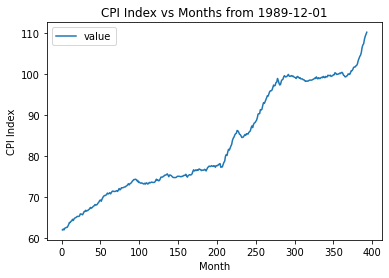

In [285]:
cpi_data = pd.read_csv(os.path.join(RAW_DIR_PATH, "cpi", "M212882.csv"))
cpi_data = cpi_data[["Data Series", "All Items "]]
cpi_data["month"] = cpi_data["Data Series"].str.strip()
cpi_data["month"] = (pd.to_datetime(cpi_data["month"], format="%Y %b") - pd.to_datetime("1989-12-01", format="%Y-%m-%d"))/np.timedelta64(1, "M")
cpi_data["month"] = round(cpi_data["month"]).astype("int")
cpi_data = cpi_data[cpi_data["month"] > 0]
cpi_data["date"] = cpi_data["Data Series"]
cpi_data["value"] = cpi_data["All Items "]
cpi_data.drop(columns=["Data Series", "All Items "], inplace=True)
cpi_indexed = cpi_data[["month", "value"]]
cpi_data["value"] = cpi_data["value"].astype(np.float32)
cpi_data.plot(x = "month", y="value", xlabel="Month", ylabel="CPI Index", title="CPI Index vs Months from 1989-12-01");

In [286]:
tx_dist = tx_dist.merge(cpi_indexed, left_on="sale_month", right_on="month")
tx_dist["cpi_psm"] = (cpi_indexed.loc[0, "value"]/tx_dist["value"]) * tx_dist["psm"]
tx_dist = tx_dist.rename(columns={"value": "cpi"})

In [287]:
tx_dist.drop(columns=["month"], inplace=True)

### Adding SORA Data
Data is from <https://eservices.mas.gov.sg/statistics/dir/DomesticInterestRates.aspx>

In [288]:
sora_data = pd.read_csv(os.path.join(RAW_DIR_PATH, "interest-rates", "sora.csv"))
sora_data = sora_data.rename(columns={"SORA Value Date": "year", "Unnamed: 1": "month", "Unnamed: 2": "date", 
                            "SORA Publication Date": "pub_date"})
sora_data["pub_date"] = pd.to_datetime(sora_data["pub_date"], format="%d %b %Y")
sora_data["month_baseline"] = (sora_data["pub_date"] - pd.to_datetime("1989-12-01", format="%Y-%m-%d"))/np.timedelta64(1, "M")
sora_data["month_baseline"] = round(sora_data["month_baseline"]).astype("int")
sora_data.head(5)

,year,month,date,pub_date,SORA,month_baseline
0,2005.0,Jul,1,2005-07-04,1.7998,187
1,NaN,NaN,4,2005-07-05,1.7480,187
2,NaN,NaN,5,2005-07-06,1.7686,187
3,NaN,NaN,6,2005-07-07,1.7971,187
4,NaN,NaN,7,2005-07-08,1.7956,187


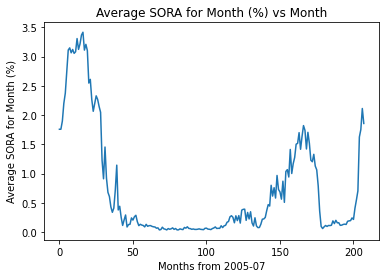

In [289]:
import matplotlib.pyplot as plt
sora_indexed = sora_data[["month_baseline", "SORA"]].set_index("month_baseline")
month_sora_dict = {}
for i, row in sora_indexed.iterrows():
  month_sora_dict[i] = month_sora_dict.get(i, []) + [row["SORA"]]
for month, lst in month_sora_dict.items():
  month_sora_dict[month] = sum(lst) / len(lst)
plt.subplot(111)
plt.plot(month_sora_dict.values())
plt.xlabel("Months from 2005-07")
plt.ylabel("Average SORA for Month (%)")
plt.title("Average SORA for Month (%) vs Month")
plt.show()

In [290]:
month_sora_df = pd.DataFrame.from_dict(month_sora_dict, orient="index", columns=["avg_sora"]).reset_index()
tx_dist = tx_dist.merge(month_sora_df, left_on="sale_month", right_on="index", how="left").drop(columns=["index"])
tx_dist.head(5)

,town,flat_type,flat_model,sale_date,floor,age,relative_tenure,floor_area,psm,address,...,nearest_post_offices,nearest_bus_stops,nearest_pharmacies,nearest_primary_schools,nearest_parks,nearest_trains,sale_month,cpi,cpi_psm,avg_sora
0,JURONG_WEST,3_ROOM,IMPROVED,1990-01-01,5.0,16,0.899953,70.0,334.285714,BLOCK 172 BOON LAY DR,...,0.798752,0.195397,0.761661,0.541789,0.947906,0.904104,1,61.9,595.125779,NaN
1,OTHER,5_ROOM,STANDARD,1990-01-01,5.0,15,0.902280,120.0,916.666667,BLOCK 3 MARINE TER,...,3.042559,0.090376,1.133326,0.159056,0.330270,1.954674,1,61.9,1631.933226,NaN
2,BUKIT_MERAH,3_ROOM,IMPROVED,1990-01-01,5.0,15,0.902280,63.0,722.222222,BLOCK 2 JLN BT MERAH,...,1.148847,0.446105,0.850333,0.943485,0.737703,0.932695,1,61.9,1285.765572,NaN
3,BUKIT_MERAH,OTHER,IMPROVED,1990-01-01,8.0,21,0.887322,29.0,251.724138,BLOCK 33 TAMAN HO SWEE,...,1.294327,1.620819,0.431442,0.691163,0.311404,0.448964,1,61.9,448.142165,NaN
4,BUKIT_MERAH,OTHER,IMPROVED,1990-01-01,11.0,21,0.887322,29.0,251.724138,BLOCK 33 TAMAN HO SWEE,...,1.294327,1.620819,0.431442,0.691163,0.311404,0.448964,1,61.9,448.142165,NaN


### Exporting Data

In [291]:
tx_dist.to_csv(os.path.join(PROCESSED_DIR_PATH, "resale_flat_prices", "engineered_data.csv"))
ft.to_csv(os.path.join(PROCESSED_DIR_PATH, "resale_flat_prices", "engineered_data_encoded.csv"))